In [1]:
import open3d as o3d
import numpy as np
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from skimage.metrics import structural_similarity as ssim_metric, peak_signal_noise_ratio as psnr_metric
import cv2  # For texture image processing
from scipy.spatial import cKDTree
from torch.optim.lr_scheduler import StepLR
import os
import subprocess
import logging

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 1. Import SF3D Model and Generate Meshes

In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Path to SF3D run.py
SF3D_RUN_SCRIPT = r"C:\Users\princ\Documents\MasterThesis\MasterThesisTMDT\Chapter_4\stable-fast-3d\run.py"

# Generate Mesh with SF3D (or reuse existing mesh)
def generate_sf3d_mesh(image_path, output_dir):
    """
    Generate a 3D mesh from an image using SF3D, or reuse an existing mesh if it already exists.

    Args:
        image_path (str): Path to the input image.
        output_dir (str): Directory to save the generated mesh.

    Returns:
        str: Path to the generated mesh file.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Define the path to the generated mesh
    mesh_path = os.path.join(output_dir, "0/mesh.glb")
    
    # Check if the mesh already exists
    if os.path.exists(mesh_path):
        logging.info(f"Reusing existing mesh at: {mesh_path}")
        return mesh_path
    
    # Ensure the SF3D run.py script exists
    if not os.path.exists(SF3D_RUN_SCRIPT):
        raise FileNotFoundError(f"SF3D run.py script not found at {SF3D_RUN_SCRIPT}")
    
    # Construct the command
    cmd = f"python {SF3D_RUN_SCRIPT} {image_path} --output-dir {output_dir}"
    
    try:
        # Run the SF3D script
        subprocess.run(cmd, shell=True, check=True)
    except subprocess.CalledProcessError as e:
        logging.error(f"SF3D mesh generation failed: {e}")
        raise
    
    # Check if the mesh file was generated
    if not os.path.exists(mesh_path):
        raise FileNotFoundError(f"Generated mesh not found at {mesh_path}")
    
    logging.info(f"Generated mesh saved at: {mesh_path}")
    return mesh_path

# Generate Training and Testing Meshes
def generate_training_and_testing_meshes(train_image_path, test_image_path, train_mesh_dir="output/train_mesh", test_mesh_dir="output/test_mesh"):
    """
    Generate meshes for training and testing images, or reuse existing meshes.

    Args:
        train_image_path (str): Path to the training image.
        test_image_path (str): Path to the testing image.
        train_mesh_dir (str): Directory to save the training mesh.
        test_mesh_dir (str): Directory to save the testing mesh.

    Returns:
        tuple: Paths to the training and testing meshes.
    """
    # Generate or reuse training mesh
    train_mesh_path = generate_sf3d_mesh(train_image_path, train_mesh_dir)
    
    # Generate or reuse testing mesh
    test_mesh_path = generate_sf3d_mesh(test_image_path, test_mesh_dir)
    
    return train_mesh_path, test_mesh_path


# 2. Mesh & Texture Loading and Preprocessing

In [3]:
def mesh_to_graph(mesh_path, simplify=True, target_triangles=1000):
    """
    Load a mesh from file, and convert to a torch_geometric Data object.
    """
    o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    mesh.remove_duplicated_vertices()
    mesh.remove_non_manifold_edges()
    
    if simplify and len(mesh.triangles) > target_triangles:
        mesh = mesh.simplify_quadric_decimation(target_number_of_triangles=target_triangles)
    
    vertices = np.asarray(mesh.vertices, dtype=np.float32)
    faces = np.asarray(mesh.triangles, dtype=np.int64)
    vertices_tensor = torch.from_numpy(vertices)
    faces_tensor = torch.from_numpy(faces)
    
    # Build edges from faces (each triangle contributes three edges)
    edges = set()
    for face in faces_tensor:
        edges.add((face[0].item(), face[1].item()))
        edges.add((face[1].item(), face[2].item()))
        edges.add((face[2].item(), face[0].item()))
    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    
    return Data(x=vertices_tensor, edge_index=edge_index, faces=faces_tensor)

def load_texture_image(texture_path):
    """
    Load a texture image (UV-unwrapped) as an RGB numpy array.
    """
    texture = cv2.imread(texture_path)
    texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
    return texture

# 3. Define the Graph Autoencoder Model

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, latent_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class GCNDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(latent_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, z, edge_index):
        z = self.conv1(z, edge_index).relu()
        z = self.conv2(z, edge_index)
        return z

class GraphAutoencoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim1=128, hidden_dim2=64, latent_dim=32):
        super().__init__()
        # Encoder layers
        self.enc_conv1 = pyg_nn.GCNConv(input_dim, hidden_dim1)
        self.enc_conv2 = pyg_nn.GCNConv(hidden_dim1, hidden_dim2)
        self.enc_conv3 = pyg_nn.GCNConv(hidden_dim2, latent_dim)
        # Decoder layers
        self.dec_conv1 = pyg_nn.GCNConv(latent_dim, hidden_dim2)
        self.dec_conv2 = pyg_nn.GCNConv(hidden_dim2, hidden_dim1)
        self.dec_conv3 = pyg_nn.GCNConv(hidden_dim1, input_dim)

    def forward(self, data):
        # Encoder
        x = F.relu(self.enc_conv1(data.x, data.edge_index))
        x = F.relu(self.enc_conv2(x, data.edge_index))
        z = self.enc_conv3(x, data.edge_index)
        # Decoder
        x = F.relu(self.dec_conv1(z, data.edge_index))
        x = F.relu(self.dec_conv2(x, data.edge_index))
        reconstructed = self.dec_conv3(x, data.edge_index)
        return reconstructed
    

'class GraphAutoencoder(torch.nn.Module):\n    def __init__(self, in_channels=3, hidden_channels=64, latent_dim=32):\n        super().__init__()\n        self.encoder = GCNEncoder(in_channels, hidden_channels, latent_dim)\n        self.decoder = GCNDecoder(latent_dim, hidden_channels, in_channels)\n\n    def forward(self, data):\n        z = self.encoder(data.x, data.edge_index)\n        reconstructed = self.decoder(z, data.edge_index)\n        return reconstructed'

# 4. Data Augmentation & Synthetic Dataset

In [ ]:

# Augmentation Functions
def augment_with_noise(data, sigma=0.005):
    noise = torch.normal(0, sigma, size=data.x.shape)
    augmented_x = data.x + noise
    return Data(x=augmented_x, edge_index=data.edge_index, face=data.face)

def augment_with_rotation(data, max_angle_deg=30):
    angles = np.random.uniform(-max_angle_deg, max_angle_deg, 3) * np.pi / 180  # Radians
    Rx = torch.tensor([[1, 0, 0], [0, np.cos(angles[0]), -np.sin(angles[0])], [0, np.sin(angles[0]), np.cos(angles[0])]], dtype=torch.float)
    Ry = torch.tensor([[np.cos(angles[1]), 0, np.sin(angles[1])], [0, 1, 0], [-np.sin(angles[1]), 0, np.cos(angles[1])]], dtype=torch.float)
    Rz = torch.tensor([[np.cos(angles[2]), -np.sin(angles[2]), 0], [np.sin(angles[2]), np.cos(angles[2]), 0], [0, 0, 1]], dtype=torch.float)
    R = Rz @ Ry @ Rx  # Combined rotation matrix
    augmented_x = data.x @ R.T  # Rotate vertices
    return Data(x=augmented_x, edge_index=data.edge_index, face=data.face)

def augment_with_scaling(data, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    augmented_x = data.x * scale
    return Data(x=augmented_x, edge_index=data.edge_index, face=data.face)

def augment_with_shear(data, shear_max=0.1):
    shear_xy = np.random.uniform(-shear_max, shear_max)
    shear_xz = np.random.uniform(-shear_max, shear_max)
    shear_yz = np.random.uniform(-shear_max, shear_max)
    shear_matrix = torch.tensor([[1, shear_xy, shear_xz], [0, 1, shear_yz], [0, 0, 1]], dtype=torch.float)
    augmented_x = data.x @ shear_matrix.T
    return Data(x=augmented_x, edge_index=data.edge_index, face=data.face)

def augment_data(data):
    """Apply all augmentations randomly."""
    aug_data = data
    if np.random.rand() < 0.8: aug_data = augment_with_noise(aug_data, sigma=0.005)
    if np.random.rand() < 0.8: aug_data = augment_with_rotation(aug_data, max_angle_deg=30)
    if np.random.rand() < 0.8: aug_data = augment_with_scaling(aug_data, scale_range=(0.9, 1.1))
    if np.random.rand() < 0.8: aug_data = augment_with_shear(aug_data, shear_max=0.1)
    return aug_data

# Generate synthetic dataset from a mesh file
def generate_synthetic_dataset(mesh_path, num_samples=1000):
    """
    Generate a synthetic dataset from a mesh file.

    Args:
        mesh_path (str): Path to the mesh file.
        num_samples (int): Number of synthetic samples to generate.

    Returns:
        list: List of augmented graph data objects.
    """
    # Convert the mesh to a graph
    original_graph = mesh_to_graph(mesh_path)

    num_normal = num_samples // 2  # 500 for 1000 samples
    num_augmented = num_samples - num_normal

    # Generate synthetic dataset
    dataset = []

    # Add normal (clean) samples
    for _ in range(num_normal):
        dataset.append(original_graph)  # Unchanged graph
    
    # Add augmented samples
    for _ in range(num_augmented):
        augmented_graph = augment_data(original_graph)
        augmented_graph.faces = original_graph.faces  # Preserve faces
        dataset.append(augmented_graph)
    
    # Shuffle the dataset
    np.random.shuffle(dataset)
    return dataset


# 5. Training the Autoencoder

In [6]:
def train_autoencoder(model, train_dataset, val_dataset, epochs=100, batch_size=32, device='cuda'):
    """Train the GAE on normal samples for 100 epochs and plot detailed training/validation loss."""
    # Data loaders using PyTorch Geometric's DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    # Move model to device
    model.to(device)
    
    # Lists to store losses
    train_losses = []
    val_losses = []
    
    # Training loop for the full 100 epochs
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstructed = model(batch)  # Ensure model handles batched graph data
            loss = torch.nn.functional.mse_loss(reconstructed, batch.x)  # Compare reconstructed and original node features
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch.num_graphs  # Scale loss by number of graphs in batch
        
        # Average training loss for the epoch
        epoch_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                reconstructed = model(batch)
                loss = torch.nn.functional.mse_loss(reconstructed, batch.x)
                total_val_loss += loss.item() * batch.num_graphs  # Scale loss by number of graphs in batch
        
        # Average validation loss for the epoch
        epoch_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Step the scheduler (learning rate reduction at epoch 30)
        scheduler.step()
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")
    
    # Epoch range for plotting (full 100 epochs)
    epochs_range = np.arange(1, epochs + 1)
    
    # Create the detailed loss plot
    # Explicitly disable LaTeX rendering to avoid FileNotFoundError
    plt.rc('text', usetex=False)  # Ensure LaTeX rendering is disabled
    plt.rc('font', family='sans-serif')  # Use a default font that doesn't require LaTeX
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_losses, label='Training Loss (MSE)', color='blue', linewidth=2)
    plt.plot(epochs_range, val_losses, label='Validation Loss (MSE)', color='orange', linewidth=2)
    
    # Add a vertical line for the learning rate step (epoch 30)
    plt.axvline(x=30, color='green', linestyle='--', label='Learning Rate Step (Epoch 30)')
    
    # Annotate the learning rate change
    lr_change_loss = val_losses[29]  # Validation loss at epoch 30
    plt.annotate('LR Reduced to 0.0001', 
                 xy=(30, lr_change_loss), 
                 xytext=(10, lr_change_loss + 0.1 * lr_change_loss),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10)
    
    # Annotate the final loss values at epoch 100
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    plt.annotate(f'Final Train Loss: {final_train_loss:.3e}', 
                 xy=(100, final_train_loss), 
                 xytext=(80, final_train_loss + 0.05 * final_train_loss),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10)
    plt.annotate(f'Final Val Loss: {final_val_loss:.3e}', 
                 xy=(100, final_val_loss), 
                 xytext=(80, final_val_loss - 0.05 * final_val_loss),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10)
    
    # Mark significant milestones (e.g., epoch 50)
    mid_epoch = 50
    mid_val_loss = val_losses[mid_epoch - 1]
    plt.plot(mid_epoch, mid_val_loss, 'o', color='purple', markersize=8, label='Midpoint (Epoch 50)')
    
    # Customize the plot with plain text (no LaTeX formatting)
    plt.title('Training and Validation Loss Over 100 Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.yscale('log')  # Use log scale for better visualization
    plt.xticks(np.arange(0, epochs + 1, 10))
    plt.ylim(min(min(train_losses), min(val_losses)) * 0.9, max(max(train_losses), max(val_losses)) * 1.1)
    
    # Ensure the images directory exists
    os.makedirs('images', exist_ok=True)
    
    # Save the plot
    plt.savefig('images/loss_plot.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return model, train_losses, val_losses

# 6. Main Pipeline: Training, Evaluation & Composite Metrics

In [7]:
    # Define paths and parameters
train_image_path = r"images/chair1.png"  # Path to the training image
test_image_path = r"images/chair2.jpg"  # Path to the testing image
train_mesh_dir = "output/train_mesh"  # Directory to save the training mesh
test_mesh_dir = "output/test_mesh"

# Generate or reuse training and testing meshes
train_mesh_path, test_mesh_path = generate_training_and_testing_meshes(train_image_path, test_image_path, train_mesh_dir, test_mesh_dir)
original_graph = mesh_to_graph(train_mesh_path, simplify=True, target_triangles=1000)

# Generate synthetic dataset
dataset = generate_synthetic_dataset(train_mesh_path, num_samples=1000)
# Check attributes
print(dataset[0])  # Should show x, edge_index, faces
# Split into train/validation (80/20)


# Split dataset
train_data = dataset[:800]          # 800 normal meshes
val_data = dataset[800:900]          # 100 normal meshes


# Initialize model
model = GraphAutoencoder()

#Train the autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoencoder().to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
trained_model, train_losses, val_losses = train_autoencoder(
    model, train_data, val_data, epochs=100, batch_size=32, device=device
)




2025-04-16 18:22:11,712 - INFO - Reusing existing mesh at: output/train_mesh\0/mesh.glb
2025-04-16 18:22:11,715 - INFO - Reusing existing mesh at: output/test_mesh\0/mesh.glb


Data(x=[500, 3], edge_index=[2, 3000], faces=[1000, 3])
Epoch 1/100, Train Loss: 0.016606, Val Loss: 0.001843
Epoch 2/100, Train Loss: 0.001377, Val Loss: 0.000798
Epoch 3/100, Train Loss: 0.000705, Val Loss: 0.000628
Epoch 4/100, Train Loss: 0.000603, Val Loss: 0.000578
Epoch 5/100, Train Loss: 0.000568, Val Loss: 0.000549
Epoch 6/100, Train Loss: 0.000546, Val Loss: 0.000534
Epoch 7/100, Train Loss: 0.000533, Val Loss: 0.000522
Epoch 8/100, Train Loss: 0.000522, Val Loss: 0.000530
Epoch 9/100, Train Loss: 0.000518, Val Loss: 0.000504
Epoch 10/100, Train Loss: 0.000508, Val Loss: 0.000497
Epoch 11/100, Train Loss: 0.000498, Val Loss: 0.000496
Epoch 12/100, Train Loss: 0.000497, Val Loss: 0.000488
Epoch 13/100, Train Loss: 0.000492, Val Loss: 0.000484
Epoch 14/100, Train Loss: 0.000488, Val Loss: 0.000481
Epoch 15/100, Train Loss: 0.000485, Val Loss: 0.000479
Epoch 16/100, Train Loss: 0.000483, Val Loss: 0.000482
Epoch 17/100, Train Loss: 0.000484, Val Loss: 0.000492
Epoch 18/100, Trai

# 7. Testing

In [14]:

def create_anomaly(graph_data, vertex_range=(100, 150), shift=(0, 0, 0.5)):
    anomalous_vertices = graph_data.x.clone()
    start, end = vertex_range
    if end > len(anomalous_vertices):
        end = len(anomalous_vertices)
    anomalous_vertices[start:end] += torch.tensor(shift, dtype=torch.float32)
    return Data(x=anomalous_vertices, edge_index=graph_data.edge_index, faces=graph_data.faces)


def add_crack(graph_data, start_vertex, end_vertex, displacement=0.1):
    modified_vertices = graph_data.x.clone()
    for i in range(start_vertex, min(end_vertex + 1, len(modified_vertices))):
        direction = torch.randn(3) * displacement  # Random direction
        modified_vertices[i] += direction
    return Data(x=modified_vertices, edge_index=graph_data.edge_index, faces=graph_data.faces)



def add_hole(graph_data, center_vertex=None, radius=0.05):
    """
    Simulate a hole by removing vertices within a radius of a center vertex.
    
    Args:
        graph_data (Data): PyG graph with x (vertices), edge_index, and faces.
        center_vertex (int, optional): Index of the center vertex. If None, pick a random vertex.
        radius (float): Radius of the hole (vertices within this distance are removed).
    
    Returns:
        Data: Modified graph with hole.
    """
    # Clone to avoid modifying the original data
    modified_vertices = graph_data.x.clone()
    modified_faces = graph_data.faces.clone()
    
    # Check if center_vertex is valid
    num_vertices = modified_vertices.shape[0]
    if center_vertex is None or center_vertex >= num_vertices:
        # Pick a random valid vertex if center_vertex is invalid
        center_vertex = torch.randint(0, num_vertices, (1,)).item()
    
    # Calculate distances from the center vertex
    distances = torch.norm(modified_vertices - modified_vertices[center_vertex], dim=1)
    mask = distances > radius
    
    # Check if the radius is too large
    if mask.sum() == 0:
        raise ValueError(f"Radius {radius} is too large. All vertices would be removed.")
    
    # Remove vertices within the radius
    modified_vertices = modified_vertices[mask]
    
    # Create a mapping from old vertex indices to new indices
    old_to_new = torch.full((num_vertices,), -1, dtype=torch.long)
    new_index = 0
    for old_index in range(num_vertices):
        if mask[old_index]:
            old_to_new[old_index] = new_index
            new_index += 1
    
    # Remove faces containing deleted vertices and update vertex indices
    valid_faces = []
    for face in modified_faces:
        if mask[face[0]] and mask[face[1]] and mask[face[2]]:
            # Update face indices to new vertex indices
            new_face = torch.tensor([
                old_to_new[face[0]],
                old_to_new[face[1]],
                old_to_new[face[2]]
            ], dtype=torch.long)
            valid_faces.append(new_face)
    
    if not valid_faces:
        # Calculate the maximum allowed radius
        max_radius = distances.max().item()
        raise ValueError(
            f"No valid faces left after adding the hole. Try a smaller radius (max allowed: {max_radius:.2f})."
        )
    
    modified_faces = torch.stack(valid_faces)
    
    # Rebuild edges from remaining faces
    edges = set()
    for face in modified_faces:
        edges.add((face[0].item(), face[1].item()))
        edges.add((face[1].item(), face[2].item()))
        edges.add((face[2].item(), face[0].item()))
    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)
    
    return Data(x=modified_vertices, edge_index=edge_index, faces=modified_faces)

def add_random_noise(graph_data, noise_scale=0.1, fraction=0.1):
    modified_vertices = graph_data.x.clone()
    num_vertices = len(modified_vertices)
    idx = np.random.choice(num_vertices, int(num_vertices * fraction), replace=False)
    modified_vertices[idx] += torch.randn(len(idx), 3) * noise_scale
    return Data(x=modified_vertices, edge_index=graph_data.edge_index, faces=graph_data.faces)




# 8. Visualize Results

In [9]:
import os
def compute_vertex_errors(model, data):
    """Compute per-vertex reconstruction error."""
    model.eval()
    with torch.no_grad():
        reconstructed = model(data)
        error = torch.mean((data.x - reconstructed)**2, dim=1)
    return error.cpu().numpy()


def identify_hole_vertices(normal_data, anomalous_data):
    normal_vertices = normal_data.x.numpy()
    anomalous_vertices = anomalous_data.x.numpy()
    
    print(f"Normal vertices shape: {normal_vertices.shape}, Sample: {normal_vertices[:5]}")
    print(f"Anomalous vertices shape: {anomalous_vertices.shape}, Sample: {anomalous_vertices[:5]}")
    
    num_normal = len(normal_vertices)
    num_anomalous = len(anomalous_vertices)
    
    if num_normal == num_anomalous:
        print("No vertex difference detected.")
        return None, 0
    
    num_removed = abs(num_normal - num_anomalous)
    print(f"Vertex difference detected: {num_removed}")
    # No hole_mask unless you confirm test_data[17] is a hole with known locations
    return None, num_removed


def visualize_mesh_with_heatmap_and_hole(graph_data, error, hole_mask=None, normal_vertices=None, center_vertex=None, radius=None, offset=[0, 0, 0]):
    """Visualize a mesh with heatmap and hole boundary if applicable."""
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(graph_data.x.numpy() + np.array(offset))
    mesh.triangles = o3d.utility.Vector3iVector(graph_data.faces.numpy())
    
    # Base heatmap for reconstruction errors
    error_norm = (error - error.min()) / (error.max() - error.min() + 1e-6)
    colors = plt.cm.viridis(error_norm)[:, :3]  # Blue (low) to yellow (high)
    
    # Highlight hole boundary if present
    if hole_mask is not None and normal_vertices is not None:
        normal_pos = normal_vertices[center_vertex]
        distances = np.linalg.norm(graph_data.x.numpy() - normal_pos, axis=1)
        boundary_mask = (distances <= radius * 1.2) & (distances > radius * 0.8)
        colors[boundary_mask] = [1, 0, 0]  # Red for hole boundary
    
    mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    return mesh

def visualize_normal_vs_anomalous_with_hole(model, normal_data, anomalous_data, center_vertex=10, radius=0.5, threshold=None, save_path="images/mesh_visualization.png"):
    """Visualize normal and anomalous meshes, marking hole if present."""
    # Compute errors
    normal_error = compute_vertex_errors(model, normal_data)
    anomalous_error = compute_vertex_errors(model, anomalous_data)
    
    # Identify hole vertices (if any)
    #hole_mask, num_removed = identify_hole_vertices(normal_data, anomalous_data, center_vertex, radius)
    hole_mask, num_removed = identify_hole_vertices(normal_data, anomalous_data)
    # Create meshes
    normal_mesh = visualize_mesh_with_heatmap_and_hole(
        normal_data, normal_error, offset=[0, 0, 0]
    )
    anomalous_mesh = visualize_mesh_with_heatmap_and_hole(
        anomalous_data, anomalous_error, 
        hole_mask=hole_mask if num_removed > 0 else None,
        normal_vertices=normal_data.x.numpy() if num_removed > 0 else None,
        center_vertex=center_vertex, radius=radius, offset=[2, 0, 0]
    )
    
    # Visualize
    o3d.visualization.draw_geometries(
        [normal_mesh, anomalous_mesh],
        window_name="Normal vs Anomalous Mesh (Hole Highlighted if Present)",
        width=1200,
        height=600
    )
    
    # Stats
    normal_anomaly_mask = normal_error > threshold
    anomalous_anomaly_mask = anomalous_error > threshold
    print(f"Normal Mesh - Vertices: {len(normal_data.x)}, Anomalous Vertices: {np.sum(normal_anomaly_mask)} ({np.mean(normal_anomaly_mask)*100:.2f}%)")
    print(f"Anomalous Mesh - Vertices: {len(anomalous_data.x)}, Anomalous Vertices: {np.sum(anomalous_anomaly_mask)} ({np.mean(anomalous_anomaly_mask)*100:.2f}%)")
    print(f"Hole Vertices (Removed): {num_removed}")
    print(f"Normal Error - Max: {normal_error.max():.6f}, Mean: {normal_error.mean():.6f}")
    print(f"Anomalous Error - Max: {anomalous_error.max():.6f}, Mean: {anomalous_error.mean():.6f}")

    # Create a visualizer and save the image
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=1200, height=600, visible=False)  # Invisible window for batch processing
    vis.add_geometry(normal_mesh)
    vis.add_geometry(anomalous_mesh)
    vis.poll_events()
    vis.update_renderer()
    # Save to current working directory
    vis.capture_screen_image(save_path)  # Relative path saves to cwd
    print(f"Visualization saved to: {os.path.abspath(save_path)}")  # Confirm the save location
    vis.destroy_window()

    return anomalous_error.mean()
test_normal = dataset[900:1000]  # 10 normal for testing

test_anomalous = (
    [create_anomaly(original_graph) for _ in range(40)] +
    [add_crack(original_graph, 110, 150) for _ in range(30)] +
    [add_hole(original_graph, center_vertex=10, radius=0.3) for _ in range(30)]
)
test_data = test_normal + test_anomalous

# Usage with test data
normal_sample = test_data[0]  # First normal sample
anomalous_sample = test_data[120]  # Anomalous sample (e.g., hole)

# Compute threshold
val_errors = []
for data in val_data:
    reconstructed = model(data)
    val_errors.append(torch.mean((data.x - reconstructed)**2).item())
threshold = np.quantile(val_errors, 0.9)

# Visualize
visualize_normal_vs_anomalous_with_hole(model, normal_sample, anomalous_sample, center_vertex=10, radius=0.5, threshold=threshold)



Normal vertices shape: (500, 3), Sample: [[ 0.21222943 -0.4426232  -0.15108216]
 [-0.21205857 -0.44013166 -0.16097015]
 [ 0.22811407 -0.42242265 -0.14292388]
 [ 0.22792883 -0.40247014 -0.15805861]
 [ 0.21949615 -0.415561   -0.13062176]]
Anomalous vertices shape: (500, 3), Sample: [[ 0.21222943 -0.4426232  -0.15108216]
 [-0.21205857 -0.44013166 -0.16097015]
 [ 0.22811407 -0.42242265 -0.14292388]
 [ 0.22792883 -0.40247014 -0.15805861]
 [ 0.21949615 -0.415561   -0.13062176]]
No vertex difference detected.
Normal Mesh - Vertices: 500, Anomalous Vertices: 84 (16.80%)
Anomalous Mesh - Vertices: 500, Anomalous Vertices: 237 (47.40%)
Hole Vertices (Removed): 0
Normal Error - Max: 0.002876, Mean: 0.000370
Anomalous Error - Max: 0.063658, Mean: 0.004182
Visualization saved to: c:\Users\princ\Documents\MasterThesis\MasterThesisTMDT\Chapter_4\images\mesh_visualization.png


0.004182251

# 9. Compute Metrics AUC, F1, Precision, Recall

AUC: 0.90, F1: 0.81, Precision: 0.96, Recall: 0.70


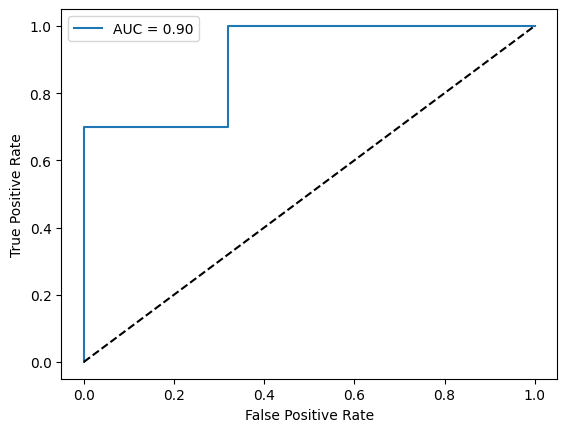

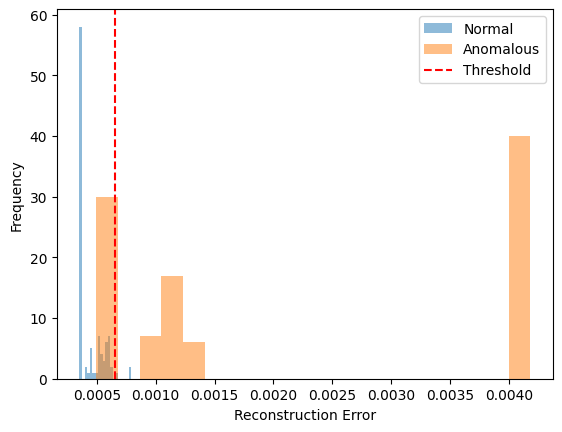

False positive indices: [40, 63, 66]
Sample 5 (normal) error: 0.0005, Threshold: 0.0007


In [10]:


# 5. Set threshold using validation data
val_errors = []
for data in val_data:
    reconstructed = model(data)
    val_errors.append(torch.mean((data.x - reconstructed)**2).item())
threshold = np.quantile(val_errors, 0.95)


# 6. Evaluate on test set
y_true = np.array([0]*100 + [1]*100)  # 10 normal, 10 anomalies
y_scores = []
for data in test_data:
    reconstructed = model(data)
    error = torch.mean((data.x - reconstructed)**2).item()
    y_scores.append(error)


# 7. Compute metrics
auc = roc_auc_score(y_true, y_scores)
y_pred = (np.array(y_scores) > threshold).astype(int)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"AUC: {auc:.2f}, F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

plt.hist([s for s, y in zip(y_scores, y_true) if y == 0], bins=20, alpha=0.5, label="Normal")
plt.hist([s for s, y in zip(y_scores, y_true) if y == 1], bins=20, alpha=0.5, label="Anomalous")
plt.axvline(threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#threshold = np.quantile(val_errors, 0.9)
y_pred = (np.array(y_scores) > threshold).astype(int)
false_positives = [i for i, (score, pred, true) in enumerate(zip(y_scores, y_pred, y_true)) if pred == 1 and true == 0]
print("False positive indices:", false_positives)

for i in [5]:
    sample = test_data[i]
    reconstructed = model(sample)
    error = torch.mean((sample.x - reconstructed)**2).item()
    print(f"Sample {i} (normal) error: {error:.4f}, Threshold: {threshold:.4f}")

Number of vertices in normal sample: 500
Number of vertices in anomalous sample: 500
Plotting for 500 vertices
ECG-style plot saved to: c:\Users\princ\Documents\MasterThesis\MasterThesisTMDT\Chapter_4\images\reconstruction_errors_ecg_style.png


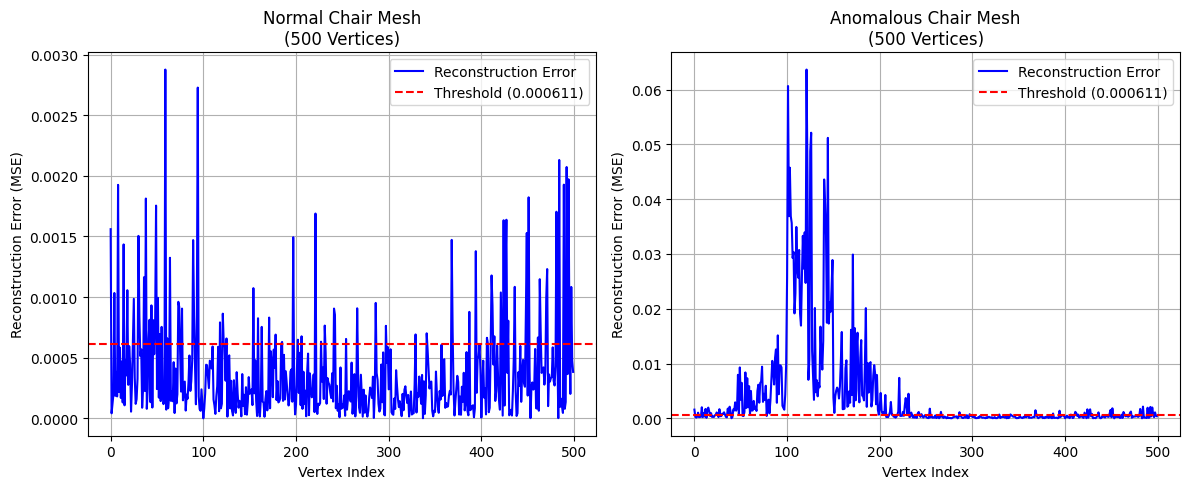

In [15]:
def plot_reconstruction_errors(normal_sample, anomalous_sample, model, threshold, save_path="images/reconstruction_errors_ecg_style.png"):
    """Generate ECG-style plots for per-vertex reconstruction errors of normal and anomalous meshes."""
    # Compute per-vertex reconstruction errors
    normal_errors = compute_vertex_errors(model, normal_sample)  # Shape: (num_vertices,)
    anomalous_errors = compute_vertex_errors(model, anomalous_sample)  # Shape: (num_vertices,)

    # Determine the number of vertices to plot
    num_vertices_normal = len(normal_errors)
    num_vertices_anomalous = len(anomalous_errors)
    num_vertices = min(num_vertices_normal, num_vertices_anomalous)
    print(f"Number of vertices in normal sample: {num_vertices_normal}")
    print(f"Number of vertices in anomalous sample: {num_vertices_anomalous}")
    print(f"Plotting for {num_vertices} vertices")

    # Create subplots for normal and anomalous errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for normal mesh
    ax1.grid()
    ax1.plot(np.arange(num_vertices), normal_errors[:num_vertices], color='blue', label='Reconstruction Error')
    ax1.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.6f})')
    ax1.set_title(f"Normal Chair Mesh\n({num_vertices_normal} Vertices)")
    ax1.set_xlabel("Vertex Index")
    ax1.set_ylabel("Reconstruction Error (MSE)")
    ax1.legend()

    # Plot for anomalous mesh
    ax2.grid()
    ax2.plot(np.arange(num_vertices), anomalous_errors[:num_vertices], color='blue', label='Reconstruction Error')
    ax2.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.6f})')
    ax2.set_title(f"Anomalous Chair Mesh\n({num_vertices_anomalous} Vertices)")
    ax2.set_xlabel("Vertex Index")
    ax2.set_ylabel("Reconstruction Error (MSE)")
    ax2.legend()

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"ECG-style plot saved to: {os.path.abspath(save_path)}")
    plt.show()


# Call the function after computing the threshold
# Assuming model, normal_sample, anomalous_sample, and threshold are already defined
plot_reconstruction_errors(normal_sample, anomalous_sample, model, threshold=0.000611)

# 10. Compute Reconstruction errors

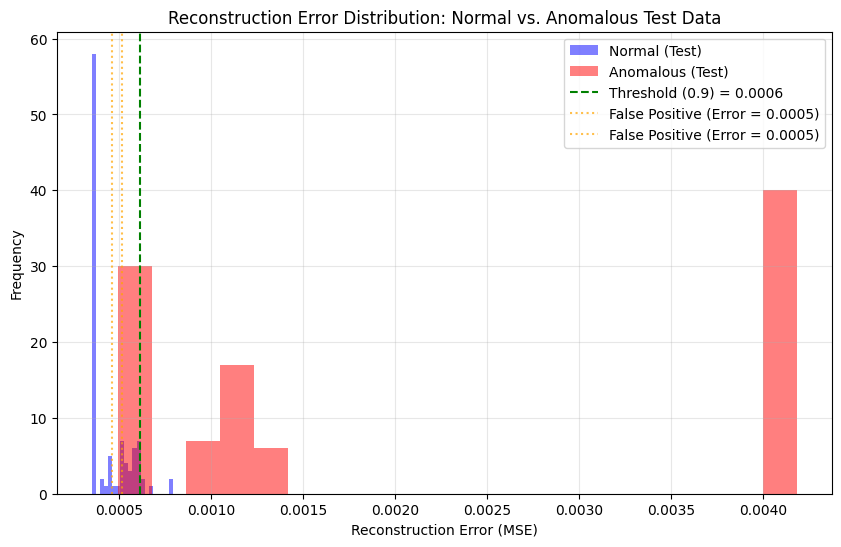

Normal Errors: Mean = 0.0004, Std = 0.0001
Anomalous Errors: Mean = 0.0022, Std = 0.0017
Threshold: 0.0006
False Positive Errors: [0.00046125336666591465, 0.0005164901958778501]


In [16]:


# Step 1: Compute reconstruction errors for all test samples
y_scores = []
model.eval()
with torch.no_grad():
    for data in test_data:
        reconstructed = model(data)
        error = torch.mean((data.x - reconstructed)**2).item()  # Same as in test loop
        y_scores.append(error)

# Step 2: Separate normal and anomalous errors
normal_errors = [score for score, label in zip(y_scores, y_true) if label == 0]
anomalous_errors = [score for score, label in zip(y_scores, y_true) if label == 1]

# Step 3: Compute threshold (if not already done)
val_errors = []
for data in val_data:
    reconstructed = model(data)
    val_errors.append(torch.mean((data.x - reconstructed)**2).item())
threshold = np.quantile(val_errors, 0.9)

# Step 4: Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=20, alpha=0.5, label="Normal (Test)", color="blue")
plt.hist(anomalous_errors, bins=20, alpha=0.5, label="Anomalous (Test)", color="red")
plt.axvline(threshold, color="green", linestyle="--", label=f"Threshold (0.9) = {threshold:.4f}")

# Step 5: Highlight false positives (indices 4 and 5)
false_positive_errors = [y_scores[4], y_scores[5]]
for fp_error in false_positive_errors:
    plt.axvline(fp_error, color="orange", linestyle=":", label=f"False Positive (Error = {fp_error:.4f})", alpha=0.7)

# Customize plot
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution: Normal vs. Anomalous Test Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print some stats for context
print(f"Normal Errors: Mean = {np.mean(normal_errors):.4f}, Std = {np.std(normal_errors):.4f}")
print(f"Anomalous Errors: Mean = {np.mean(anomalous_errors):.4f}, Std = {np.std(anomalous_errors):.4f}")
print(f"Threshold: {threshold:.4f}")
print(f"False Positive Errors: {false_positive_errors}")

# 11. Test on New Mesh

2025-04-16 19:12:22,882 - INFO - Test mesh converted to graph with 496 vertices.
2025-04-16 19:12:24,321 - INFO - Threshold from validation data: 0.000614
2025-04-16 19:12:24,538 - INFO - Testing mesh converted to graph with 496 vertices.


Normal vertices shape: (500, 3), Sample: [[ 0.21222943 -0.4426232  -0.15108216]
 [-0.21205857 -0.44013166 -0.16097015]
 [ 0.22811407 -0.42242265 -0.14292388]
 [ 0.22792883 -0.40247014 -0.15805861]
 [ 0.21949615 -0.415561   -0.13062176]]
Anomalous vertices shape: (496, 3), Sample: [[ 0.2570366  -0.39976305 -0.06103206]
 [ 0.21965462 -0.4018279  -0.06695724]
 [ 0.23888665 -0.39610347 -0.04025307]
 [ 0.21398342 -0.39609018 -0.05847067]
 [-0.04483768 -0.4175933  -0.21014765]]
Vertex difference detected: 4


2025-04-16 19:12:26,471 - INFO - Mean reconstruction error for testing mesh: 0.000645
2025-04-16 19:12:26,483 - WARNING - Anomaly detected in the test mesh!


Normal Mesh - Vertices: 500, Anomalous Vertices: 84 (16.80%)
Anomalous Mesh - Vertices: 496, Anomalous Vertices: 160 (32.26%)
Hole Vertices (Removed): 4
Normal Error - Max: 0.002876, Mean: 0.000370
Anomalous Error - Max: 0.007177, Mean: 0.000645
Visualization saved to: c:\Users\princ\Documents\MasterThesis\MasterThesisTMDT\Chapter_4\test_mesh_evaluation.png
Number of vertices in normal sample: 500
Number of vertices in anomalous sample: 496
Plotting for 496 vertices
ECG-style plot saved to: c:\Users\princ\Documents\MasterThesis\MasterThesisTMDT\Chapter_4\images\reconstruction_errors_real_world_ecg_style.png


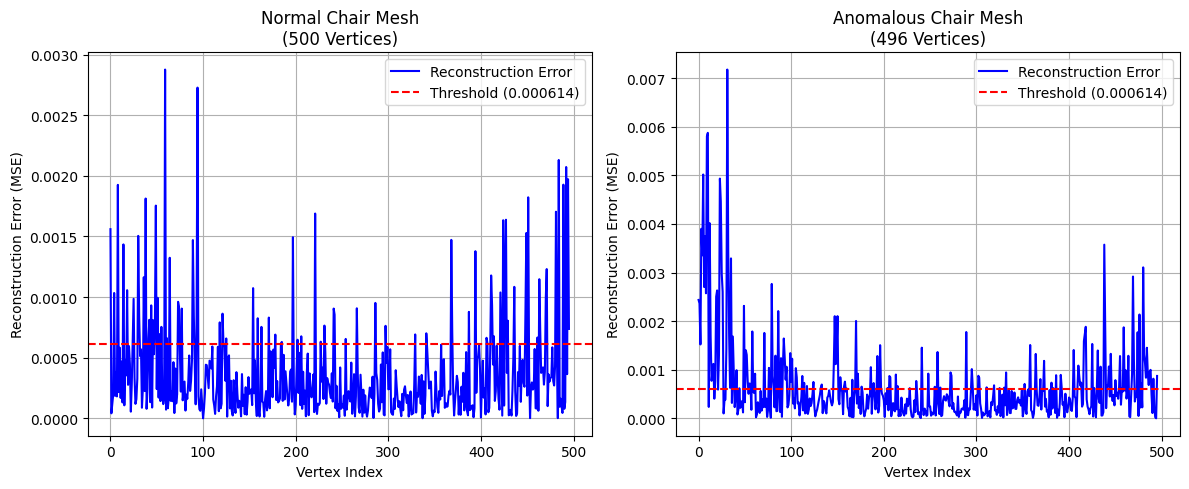

In [17]:
import os
import torch
from torch_geometric.data import Data

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Path to the test mesh directory
test_mesh_dir = "output/test_mesh"
test_mesh_path = os.path.join(test_mesh_dir, "0/mesh.glb")

# Ensure the test mesh exists
if not os.path.exists(test_mesh_path):
    raise FileNotFoundError(f"Test mesh not found at {test_mesh_path}")

# Convert the test mesh to a graph
test_graph = mesh_to_graph(test_mesh_path)
logging.info(f"Test mesh converted to graph with {test_graph.num_nodes} vertices.")


# Calculate Threshold
def calculate_threshold(model, val_data, percentile=0.9):
    """
    Calculate the anomaly detection threshold using validation data.

    Args:
        model (torch.nn.Module): Trained model.
        val_data (list): List of validation data samples.
        percentile (float): Percentile for threshold calculation.

    Returns:
        float: Calculated threshold.
    """
    val_errors = []
    for data in val_data:
        reconstructed = model(data)
        val_errors.append(torch.mean((data.x - reconstructed)**2).item())
    threshold = np.quantile(val_errors, percentile)
    logging.info(f"Threshold from validation data: {threshold:.6f}")
    return threshold

def test_new_image(test_mesh_path, model, normal_sample, threshold, save_path="test_mesh_evaluation.png"):
    """
    Test a new mesh by converting it to a graph and evaluating it.

    Args:
        test_mesh_path (str): Path to the testing mesh.
        model (torch.nn.Module): Trained model.
        normal_sample (Data): Reference normal sample from synthetic data.
        threshold (float): Anomaly detection threshold.
        save_path (str): Path to save the visualization.

    Returns:
        float: Mean reconstruction error for the new mesh.
    """
    # Convert the test mesh to a graph
    new_data = mesh_to_graph(test_mesh_path)
    logging.info(f"Testing mesh converted to graph with {new_data.num_nodes} vertices.")
    
    # Visualize and evaluate against a normal sample
    mean_error = visualize_normal_vs_anomalous_with_hole(
        model, normal_sample, new_data, center_vertex=10, radius=0.5, threshold=threshold, save_path=save_path
    )
    logging.info(f"Mean reconstruction error for testing mesh: {mean_error:.6f}")
    return mean_error

def detect_anomalies(model, data, threshold):
    model.eval()
    with torch.no_grad():
        reconstructed = model(data)
        error = torch.mean((data.x - reconstructed)**2, dim=1)  # Vertex-wise MSE
        max_error = error.max().item()
        anomaly_mask = (error > threshold).cpu().numpy()
        anomaly_percentage = anomaly_mask.mean() * 100
    return max_error, anomaly_percentage

# Main Script
if __name__ == "__main__":
    # Define paths and parameters
    test_mesh_dir = "output/test_mesh"
    test_mesh_path = os.path.join(test_mesh_dir, "0/mesh.glb")
    new_graph = mesh_to_graph(test_mesh_path, simplify=True, target_triangles=1000)
    # Ensure the test mesh exists
    if not os.path.exists(test_mesh_path):
        raise FileNotFoundError(f"Test mesh not found at {test_mesh_path}")

    # Calculate threshold using validation data (if not already done)
    threshold = calculate_threshold(model, val_data, percentile=0.9)

    # Evaluate the test mesh
    normal_sample = test_data[0]  # Reference normal sample from synthetic data
    mean_error = test_new_image(test_mesh_path, model, normal_sample, threshold, save_path="test_mesh_evaluation.png")
    #visualize_normal_vs_anomalous_with_hole(model, normal_sample, new_graph, center_vertex=10, radius=0.5, threshold=threshold)

    # Evaluate the test mesh
    max_error, anomaly_percentage = detect_anomalies(model, test_graph, threshold)
    if max_error > threshold or anomaly_percentage > 10:  # Adjust thresholds as needed
        logging.warning("Anomaly detected in the test mesh!")
    else:
        logging.info("No anomaly detected in the test mesh.")

# Generate ECG-style plot for real-world mesh
plot_reconstruction_errors(normal_sample, test_graph, model, threshold, save_path="images/reconstruction_errors_real_world_ecg_style.png")

